In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))

In [3]:
import ee 
import geemap

# ee.Initialize(project="ee-india-reservoirs")
ee.Initialize(project="ee-sahellakes")
# ee.Initialize(project="thurgau-irrigation")

In [4]:
import importlib
from src.et_green.compute_et_green import compute_et_green, calculate_band_std_dev
from src.et_green.filter_nutzungsflaechen import (
    get_crops_to_exclude,
    get_rainfed_reference_crops,
    create_crop_filters,
    filter_crops,
    add_double_cropping_info,
    get_unique_nutzung,
)
from src.et_green import exporting_utils
importlib.reload(exporting_utils)
from src.et_green.exporting_utils import (
    process_et_green, 
    prepare_rainfed_fields,
    process_et_green_RF,
    process_et_green_RF_uncertainty
    )

from utils.ee_utils import (
    back_to_float,
    back_to_int,
    export_image_to_asset,
    print_value_ranges,
    is_image_empty,
    fill_gaps_with_zeros
)

from utils.date_utils import print_collection_dates, merge_same_date_images

---

## Constants

In [5]:
YEAR = 2018

adm1_units = ee.FeatureCollection('projects/thurgau-irrigation/assets/GIS/Kantone_simplified100m')

#filter the cantons Zürich, Schaffhausen, and Thurgau from adm1_units using the 'NAME' property
adm1_units = adm1_units.filter(ee.Filter.inList('NAME', ['Zürich', 'Schaffhausen', 'Thurgau']))

TEMPORAL_RESOLUTION = "dekadal"

# Thurgau
PATH_TO_DOUBLE_CROPPING_COLLECTION = f"projects/thurgau-irrigation/assets/ZH_SH_TG/crop_vegetation_period_{YEAR}_harmonic"
PATH_TO_LANDUSE = f"projects/thurgau-irrigation/assets/ZH_SH_TG/Nutzungsflaechen/ZH_SH_TG_{YEAR}_Kulturen"
PATH_TO_RAINFED_REFERENCE_FIELDS = f"projects/thurgau-irrigation/assets/ZH_SH_TG/Rainfed_reference_fields/ZH_SH_TG_{YEAR}_Rainfed_b15"

LANDUSE_PROPERTY_NAME = "nutzung"

rainfed_reference_set = {
    "Extensiv genutzte Weiden",
    "Weiden (Heimweiden, übrige Weiden ohne Sömmerungsweiden)",
    "Übrige Dauerwiesen (ohne Weiden)",
    "Übrige Grünfläche (Dauergrünfläche), beitragsberechtigt",
    "Extensiv genutzte Wiesen (ohne Weiden)",
    "Weide (Heimweiden, üb. Weide ohne Sö.geb.)",
    "Weide (Heimweiden, üb. Weide ohne Sö.weiden)"
}

ET_GREEN_BAND_NAME = "ET_green"

# Landsat
ET_BAND_NAME = "ET"
SCALING_FACTOR = 10000
DYNAMIC = True
SCALING_FACTOR_PROPERTY_NAME = "days" if DYNAMIC else None
NUMBER_OF_IMAGES = 21
EXPORT_IMAGE_RESOLUTION = 30  # in meters
ET_BAND_RESOLUTION = 30  # 30# in meters

KANTON = "Thurgau"
PATH_TO_ET_PRODUCT_1 = f"projects/thurgau-irrigation/assets/{KANTON}/ET_products/decadal_Landsat_30m"
KANTON = "Zuerich"
PATH_TO_ET_PRODUCT_2 = f"projects/thurgau-irrigation/assets/{KANTON}/ET_products/decadal_Landsat_30m"
KANTON = "Schaffhausen"
PATH_TO_ET_PRODUCT_3 = f"projects/thurgau-irrigation/assets/{KANTON}/ET_products/decadal_Landsat_30m"

MINIMUM_FIELD_SIZE = 10000  # in square meters
MAXIMUM_NUMBER_OF_TREES = 5

PERIMETER_OF_INTEREST='projects/thurgau-irrigation/assets/Schaffhausen/perimeter_bew_oberflaechengew'

## 1. Load Assets

In [6]:
aoi = adm1_units.geometry()
jurisdictions = adm1_units

In [7]:
double_cropping_image = ee.Image(PATH_TO_DOUBLE_CROPPING_COLLECTION)
double_cropping_image = double_cropping_image.select('isDoubleCropping').where(double_cropping_image.select('secondStart').lte(5),0)
print('double cropping image:', double_cropping_image.bandNames().getInfo())

# Define vegetation period image for use in advanced processing
vegetation_period_image = ee.Image(PATH_TO_DOUBLE_CROPPING_COLLECTION)
print('veg period image:', vegetation_period_image.bandNames().getInfo())

double cropping image: ['isDoubleCropping']
veg period image: ['firstStart', 'firstEnd', 'secondStart', 'secondEnd', 'isDoubleCropping']


In [9]:
etf_collection = (
    ee.ImageCollection(PATH_TO_ET_PRODUCT_1 + "_ETF")
    .merge(ee.ImageCollection(PATH_TO_ET_PRODUCT_2 + "_ETF"))
    .merge(ee.ImageCollection(PATH_TO_ET_PRODUCT_3 + "_ETF"))
    .filterDate(f"{YEAR}-05-01", f"{YEAR}-09-30")
    .map(lambda img: back_to_float(img, SCALING_FACTOR, False))
)

# Mosaic images with identical dates
etf_collection = merge_same_date_images(etf_collection).sort("system:time_start")
print(f"Sizing of the ETF collection: {etf_collection.size().getInfo()}")
print_collection_dates(etf_collection)

etf_collection = etf_collection.toList(etf_collection.size())

Sizing of the ETF collection: 15
Dates of images in the collection:
2018-05-01
2018-05-11
2018-05-21
2018-06-01
2018-06-11
2018-06-21
2018-07-01
2018-07-11
2018-07-21
2018-08-01
2018-08-11
2018-08-21
2018-09-01
2018-09-11
2018-09-21


In [10]:
landuse_collection = ee.FeatureCollection(PATH_TO_LANDUSE)

landuse_collection = (
    landuse_collection.map(lambda f: f.set("nutzung", f.get(LANDUSE_PROPERTY_NAME)))
    if LANDUSE_PROPERTY_NAME != "nutzung"
    else landuse_collection
)

print(
    f"Renamed {LANDUSE_PROPERTY_NAME} to 'nutzung'"
    if LANDUSE_PROPERTY_NAME != "nutzung"
    else "Collection has 'nutzung' property"
)

rainfed_collection = ee.FeatureCollection(PATH_TO_RAINFED_REFERENCE_FIELDS) 

#check: aggregate_array of the 'nutzung' property
print("Rainfed reference crops in the collection:", rainfed_collection.aggregate_array('nutzung').distinct().getInfo())

PATH_TO_LANDUSE_2024 = f"projects/thurgau-irrigation/assets/ZH_SH_TG/Nutzungsflaechen/ZH_SH_TG_2024_Kulturen"
n_trees= ee.FeatureCollection(PATH_TO_LANDUSE_2024).reduceToImage(properties=['anzahl_bae'], reducer=ee.Reducer.first())

Collection has 'nutzung' property
Rainfed reference crops in the collection: ['Übrige Dauerwiesen (ohne Weiden)']


In [11]:
forest_proximity = ee.Image('projects/thurgau-irrigation/assets/Wald_SWISSTLM3D_2023_proximity')  # Path to forest proximity image
rhiresD = ee.ImageCollection('projects/thurgau-irrigation/assets/Precipitation/RhiresD')  # Path to precipitation data
DEM = ee.ImageCollection('COPERNICUS/DEM/GLO30').select("DEM")  # Path to digital elevation model
proj = DEM.first().select(0).projection()
DEM = DEM.mosaic().setDefaultProjection(proj)

In [12]:
# Load soil properties - using simplified version from export_ET_green
BODENHINWEIS_FC_ASSET = 'projects/thurgau-irrigation/assets/Bodenhinweiskarte'

depths = ['0_30_cm']               
props = ['clay', 'silt', 'sand', 'soc', 'CECpot']  

def load_soil(prop, depth):
    # Build asset ID
    img = ee.Image(f'{BODENHINWEIS_FC_ASSET}/Soil_{prop}_{depth}')
    img = img.toFloat()
    return img.rename(f'{prop}_{depth}')

# Load chosen layers
imgs = [load_soil(p, d) for p in props for d in depths]
soil_hi = ee.Image.cat(imgs)

print('Soil bands:', soil_hi.bandNames().getInfo())

Soil bands: ['clay_0_30_cm', 'silt_0_30_cm', 'sand_0_30_cm', 'soc_0_30_cm', 'CECpot_0_30_cm']


## 2. Compute ETF

In [1]:
# # You can customize these parameters for different runs:
# nutzung_filter_list = [
#     "Extensiv genutzte Weiden",
#     "Weiden (Heimweiden, übrige Weiden ohne Sömmerungsweiden)",
#     "Übrige Dauerwiesen (ohne Weiden)",
#     "Übrige Grünfläche (Dauergrünfläche), beitragsberechtigt",
#     # "Übrige Grünfläche (Dauergrünflächen), nicht beitragsberechtigt",
#     "Extensiv genutzte Wiesen (ohne Weiden)",
#     "Weide (Heimweiden, üb. Weide ohne Sö.geb.)",
#     "Weide (Heimweiden, üb. Weide ohne Sö.weiden)"
# ]
# # Set to True to enable advanced processing (vegetation periods, extreme filtering, perimeter exclusion)
# advanced_processing = False  

# ETF_ASSET_PATH = f"projects/thurgau-irrigation/assets/ZH_SH_TG/ETF/ETF_Weiden_{TEMPORAL_RESOLUTION}_from_Landsat_30m_v3"
# ##attention: I have modified the function to sample only 5000 instead of 10000 points for training to save memory
# processed_et_collection = process_et_green_RF(
#     et_collection_list=etf_collection,
#     rainfed_collection=rainfed_collection,
#     year=YEAR,
#     aoi=aoi,
#     asset_path=ETF_ASSET_PATH,
#     etf_collection_list=etf_collection,
#     forest_proximity=forest_proximity,
#     rhiresD=rhiresD,
#     DEM=DEM,
#     soil_properties=soil_hi,#soil_properties,
#     n_trees=n_trees,
#     et_band_name='ETF',
#     time_step_type=TEMPORAL_RESOLUTION,
#     resolution=ET_BAND_RESOLUTION,
#     export_band_name="ETF",
#     max_trees=MAXIMUM_NUMBER_OF_TREES,
#     nutzung_filter_list=nutzung_filter_list,
#     vegetation_period_image=vegetation_period_image,
#     advanced_processing=advanced_processing,
#     perimeter_of_interest=PERIMETER_OF_INTEREST
# )

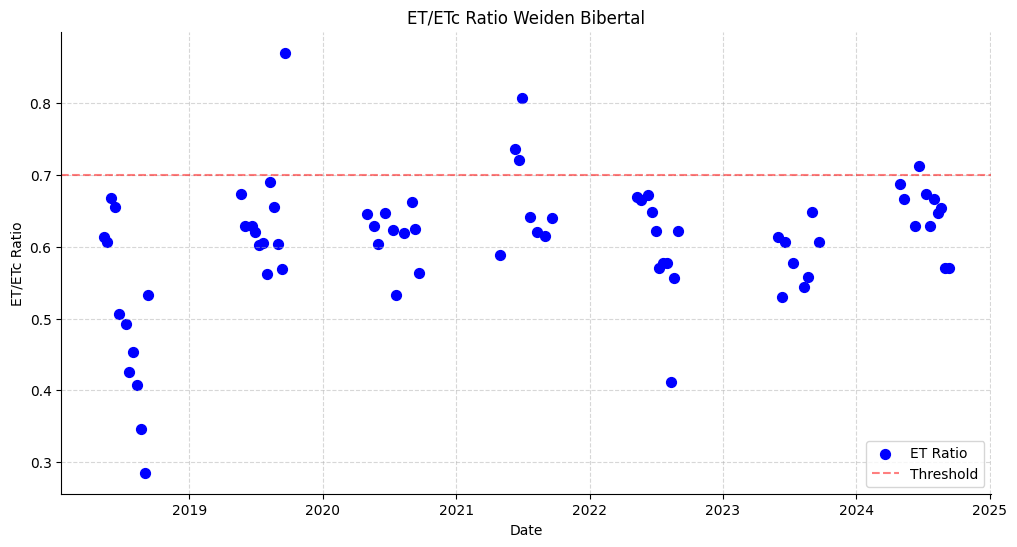

          date  min_et_1     etf_1
0   2018-05-11   18108.0  0.614355
1   2018-05-21   13131.0  0.607330
2   2018-06-01   14018.0  0.667921
3   2018-06-11   13527.0  0.655161
4   2018-06-21   11577.0  0.505986
5   2018-07-11   18466.0  0.492340
6   2018-07-21   18466.0  0.426247
7   2018-08-01   18358.0  0.453553
8   2018-08-11     384.0  0.407966
9   2018-08-21   18466.0  0.346646
10  2018-09-01     384.0  0.285251
11  2018-09-11   17595.0  0.532359
12  2019-05-11       NaN       NaN
13  2019-05-21   18466.0  0.673315
14  2019-06-01   14319.0  0.629405
15  2019-06-21   13106.0  0.629167
16  2019-07-01   18169.0  0.620756
17  2019-07-11   17717.0  0.603109
18  2019-07-21   18466.0  0.605154
19  2019-08-01   18466.0  0.561852
20  2019-08-11   18466.0  0.691047
21  2019-08-21   18466.0  0.654906
22  2019-09-01   18466.0  0.603433
23  2019-09-11   18466.0  0.569706
24  2019-09-21   11008.0  0.870506
25  2020-05-01   18466.0  0.646083
26  2020-05-21   12908.0  0.628716
27  2020-06-01   184

In [9]:
##Look at the results
ETF_ASSET_PATH = f"projects/thurgau-irrigation/assets/ZH_SH_TG/ETF/ETF_Weiden_{TEMPORAL_RESOLUTION}_from_Landsat_30m_v3"
etf_modeled = ee.ImageCollection(ETF_ASSET_PATH)
aoi=ee.FeatureCollection('projects/thurgau-irrigation/assets/Schaffhausen/perimeter_bew_oberflaechengew').geometry()
YEAR_FIRST = 2018
YEAR_LAST = 2024

etf_collection = (
    ee.ImageCollection(PATH_TO_ET_PRODUCT_1 + "_ETF")
    .merge(ee.ImageCollection(PATH_TO_ET_PRODUCT_2 + "_ETF"))
    .merge(ee.ImageCollection(PATH_TO_ET_PRODUCT_3 + "_ETF"))
    .filterDate(f"{YEAR_FIRST}-05-01", f"{YEAR_LAST}-09-30")
    .map(lambda img: back_to_float(img, SCALING_FACTOR, False))
)

# Mosaic images with identical dates
etf_collection = merge_same_date_images(etf_collection).sort("system:time_start")
# print(f"Sizing of the ETF collection: {etf_collection.size().getInfo()}")
# print_collection_dates(etf_collection)

etf_collection = etf_collection.toList(etf_collection.size())

##add "system:time_start" property to each image in the collection. Unfortunately, I forgot to export with timestamp.
## We need to get the date from the image id. Last 10 characters are the date in format YYYY_MM_D1, YYYY_MM_D2, or YYYY_MM_D3
## D1 is days 1-10, D2 is days 11-20, D3 is days 21-end of month
def add_time_start(image):
    # Get image ID and extract last 10 characters using server-side operations
    image_id = ee.String(image.id())
    date_str = image_id.slice(-10)  # Get last 10 characters
    
    # Split the date string by underscores and extract components
    parts = date_str.split('_')
    year = ee.Number.parse(parts.get(0))
    month = ee.Number.parse(parts.get(1))
    dekad_str = ee.String(parts.get(2))
    
    # Convert dekadal codes (D1, D2, D3) to day numbers (1, 11, 21)
    day = ee.Algorithms.If(
        dekad_str.compareTo('D1').eq(0), 1,
        ee.Algorithms.If(
            dekad_str.compareTo('D2').eq(0), 11,
            21  # D3
        )
    )
    day = ee.Number(day)
    
    # Create date using ee.Date.fromYMD (server-side)
    date = ee.Date.fromYMD(year, month, day)

    # filter the image of etf_collection by the timestamp and use its mask
    image = image.updateMask(ee.ImageCollection(etf_collection).filter(ee.Filter.eq('system:time_start', date.millis())).first().mask())

    # Set the "system:time_start" property
    return image.set("system:time_start", date.millis())

etf_modeled = etf_modeled.map(add_time_start)

# #lets check if that worked
# print_collection_dates(etf_collection)

import pandas as pd
import ee
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any, Optional, Union, Tuple
import numpy as np

def compute_etf_timeseries(
    etf_collections: List[ee.ImageCollection], etf_band_name: str = "ETF",
    ##add aoi as parameter
    aoi: Optional[ee.Geometry] = None
) -> pd.DataFrame:
    """Compute time series for ETF (ET ratio) from input collections.

    Args:
        etf_collections: List of ETF image collections to process.
        etf_band_name: Name of the ETF band in the images.

    Returns:
        DataFrame with columns for date and ETF statistics for each collection.
    """
    # Process each collection
    all_results = []
    for idx, collection in enumerate(etf_collections):
        results = (
            collection.map(
                lambda img: _process_single_etf_image(img, idx, etf_band_name)
            )
            .sort("date")
            .toList(collection.size())
        )
        all_results.append(results.getInfo())

    # Combine results into DataFrame
    data = []
    for time_idx in range(len(all_results[0])):
        combined_props = {}
        date_str = all_results[0][time_idx]["properties"]["date"]
        combined_props["date"] = datetime.strptime(date_str, "%Y-%m-%d").date()

        for collection_idx in range(len(etf_collections)):
            props = all_results[collection_idx][time_idx]["properties"]
            for key in [f"min_et_{collection_idx+1}", f"etf_{collection_idx+1}"]:
                combined_props[key] = props.get(key)

        data.append(combined_props)

    return pd.DataFrame(data).sort_values("date")


def _process_single_etf_image(
    image: ee.Image, collection_idx: int, etf_band_name: str = "ETF"
) -> ee.Feature:
    """Process a single image and compute ETF statistics.

    Handles empty/masked images by returning null values for statistics.

    Args:
        image: Input ETF image.
        collection_idx: Index of current collection (1-based for output naming).
        etf_band_name: Name of the ETF band in the image.

    Returns:
        Feature containing date, min_et, and ETF properties.
    """
    image_date = ee.Date(image.get("system:time_start"))

    # Check if image has any valid pixels
    valid_pixels = image.select(etf_band_name)
    valid_count = (
        valid_pixels.multiply(0)
        .add(1)
        .reduceRegion(reducer=ee.Reducer.count(), maxPixels=int(1e13), scale=30, geometry=aoi)
        .get(etf_band_name)
    )

    def compute_stats() -> ee.Feature:
        min_etf = ee.Number(
            valid_pixels.reduceRegion(
                reducer=ee.Reducer.mean(), maxPixels=int(1e13), scale=30, geometry=aoi
            ).get(etf_band_name)
        )
        count_etf = ee.Number(
            valid_pixels.reduceRegion(
                reducer=ee.Reducer.count(), maxPixels=int(1e13), scale=30, geometry=aoi
            ).get(etf_band_name)
        )
        return ee.Feature(
            None,
            {
                "date": image_date.format("YYYY-MM-dd"),
                "Month": image_date.get("month"),
                "Decade": image_date.get("day").divide(10).ceil(),
                f"min_et_{collection_idx+1}": count_etf,
                f"etf_{collection_idx+1}": min_etf,  # Assuming this is the ETF value
            },
        )

    def empty_feature() -> ee.Feature:
        return ee.Feature(
            None,
            {
                "date": image_date.format("YYYY-MM-dd"),
                f"min_et_{collection_idx+1}": None,
                f"etf_{collection_idx+1}": None,
            },
        )

    return ee.Algorithms.If(
        ee.Number(valid_count).gt(0), compute_stats(), empty_feature()
    )

# import matplotlib.pyplot as plt
# import seaborn as sns

def plot_single_et_ratio_markers_no_zeros(df: pd.DataFrame) -> None:
    """Plot ET ratio time series for a single collection using markers only, excluding zero values.

    Args:
        df: DataFrame containing a single ET ratio column (etf_1 or et_ratio_1).
    """
    # Identify the ratio column
    ratio_column = next(col for col in df.columns if col.startswith("etf_") or col.startswith("et_ratio_"))

    # Filter out zero values
    filtered_df = df[df[ratio_column] > 0]

    # Reset styles to avoid unintended global settings
    sns.reset_orig()

    # Plot only markers
    plt.figure(figsize=(12, 6))
    # plt.plot(filtered_df["date"], filtered_df[ratio_column], label="ET Ratio", color="blue", marker="o", linestyle="-", markersize=6)
    plt.scatter(filtered_df["date"], filtered_df[ratio_column], label="ET Ratio", color="blue", s=50)

    # Add threshold line
    plt.axhline(y=0.7, color="r", linestyle="--", alpha=0.5, label="Threshold")

    # Set plot details
    plt.title("ET/ETc Ratio Weiden Bibertal")
    plt.xlabel("Date")
    plt.ylabel("ET/ETc Ratio")
    plt.legend(loc="lower right")  # Set legend position to lower right
    plt.grid(True, linestyle="--", alpha=0.5)
    sns.despine()
    plt.show()


# # ratio_df = compute_et_ratio_timeseries(
# #     et_collections=[et_green_collection1 ,et_green_collection2],
# #     etc_df=etc_df,
# #     et_band_name="ET_green"
# # )
ratio_df = compute_etf_timeseries([etf_modeled], etf_band_name="ETF", aoi=aoi)


# Plot the results
plot_single_et_ratio_markers_no_zeros(ratio_df)

# You can also examine the raw data
# Set pandas options to display all rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(ratio_df)

# Reset to default after printing
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')